In [11]:
pip install -r requirements-inv.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.9 MB/s eta 0:00:0000:0100:01


Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip uninstall -y tensorflow keras

Found existing installation: keras 3.6.0
Uninstalling keras-3.6.0:
  Successfully uninstalled keras-3.6.0


In [13]:
!pip install tensorflow

  Using cached tensorflow-2.17.0-cp310-cp310-macosx_12_0_arm64.whl (236.1 MB)
  Using cached keras-3.6.0-py3-none-any.whl (1.2 MB)
  Using cached tensorboard-2.17.1-py3-none-any.whl (5.5 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2


In [15]:
!pip install scikeras --upgrade

In [16]:
# Import standard libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import keras and tensorflow for LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History

# Import scikit-learn functions and classes
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve, KFold
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer
)
from scikeras.wrappers import KerasRegressor

# For defining parameter distributions
from scipy.stats import randint, uniform

# Suppress warnings
warnings.filterwarnings('ignore')

In [17]:
# Load the cleaned DataFrame from the CSV file
df_pca_combined = pd.read_csv('df_pca_combined.csv')

# Utility Functions

In [18]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

# LSTM

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'Dataset': 'LSTM (Training)', 'MSE': 0.016669190180258045, 'RMSE': 0.12910921802976752, 'MAE': 0.09299300768722177, 'MAPE': 40.09394962517138, 'R²': 0.983203112944654, 'Adjusted R²': 0.9831987296233974, 'Training Time': 108.54529881477356}
{'Dataset': 'LSTM (Validation)', 'MSE': 0.02530407605615664, 'RMSE': 0.15907254966258835, 'MAE': 0.10886169050109297, 'MAPE': 50.179183672122086, 'R²': 0.974874656810045, 'Adjusted R²': 0.9748549661022159, 'Training Time': None}
{'Dataset': 'LSTM (Test)', 'MSE': 0.02342914833973136, 'RMSE': 0.15306583008539615, 'MAE': 0.10824934013421092, 'MAPE': 89.33523891179777, 'R²': 0.9771232137507743, 'Adjusted R²': 0.9771052992744632, 'Training Time': None}
{'Dataset': 'LSTM (CV)', 'MSE': 0.026012432646614646, 'RMSE': 0.16128370235896325, 'MAE': None, 'MAPE': None, 'R²': None, 'Adjusted R²': None, 'Training Time': None}


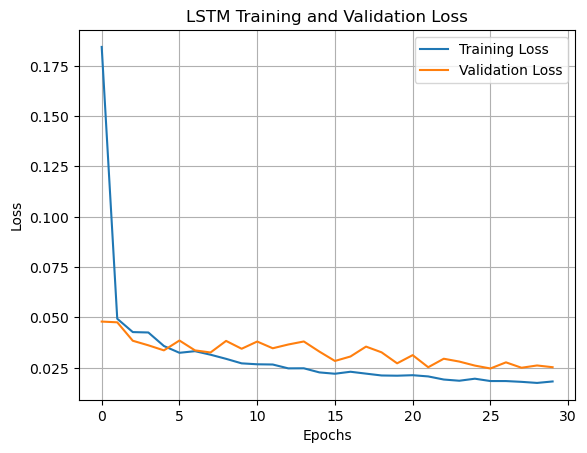

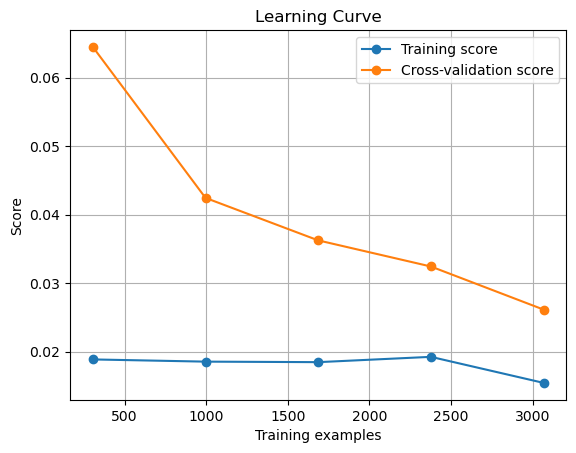

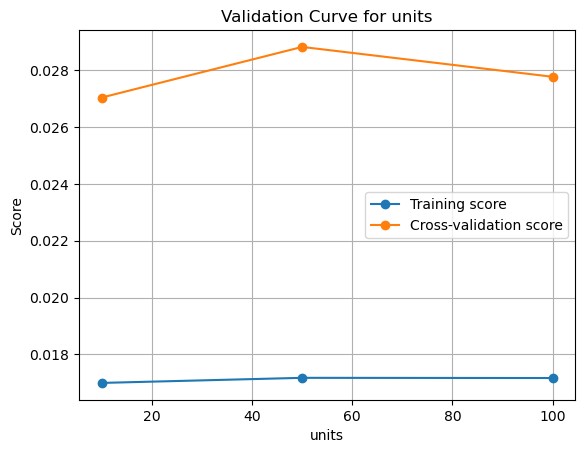

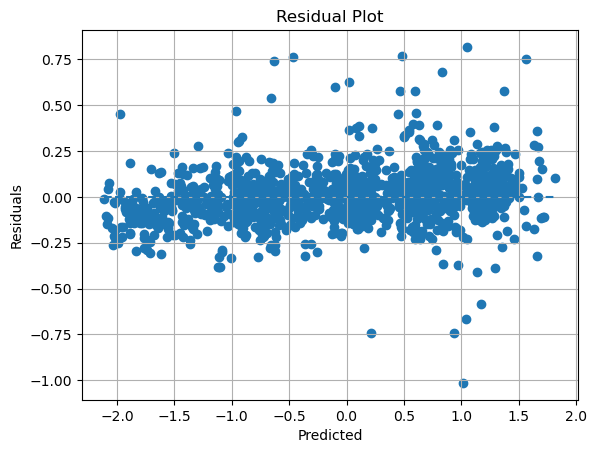

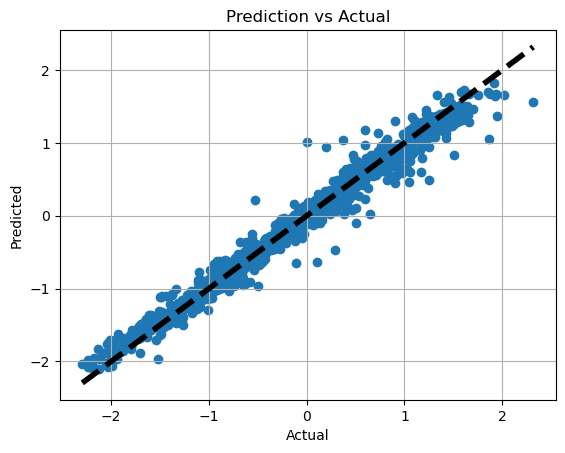

In [20]:
# Define the LSTM model
def create_lstm_model(units=50, learning_rate=0.01, input_shape=(1, 10)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Define the function to run the LSTM model with hyperparameter tuning and cross-validation
def run_lstm(df_pca_combined, target_column='Weekly_Sales', results_filename='lstm_results.csv'):
    df_lstm = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_lstm, target_column)
    
    # Reshape the data to 3D for LSTM
    X_train = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
    X_val = np.reshape(X_val.values, (X_val.shape[0], 1, X_val.shape[1]))
    X_test = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))
    
    input_shape = (1, X_train.shape[2])
    
    # KerasRegressor model wrapper using scikeras
    model = KerasRegressor(
        model=create_lstm_model,
        units=50,
        learning_rate=0.01,
        input_shape=input_shape,
        epochs=10,
        batch_size=32,
        verbose=0
    )

    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'units': [10, 50, 100],
        'learning_rate': [0.001, 0.01, 0.1],
        'batch_size': [16, 32, 64],
        'epochs': [10, 20, 30]
    }
    
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    random_search.fit(X_train, y_train, validation_data=(X_val, y_val))
    training_time = time.time() - start_time
    
    best_model = random_search.best_estimator_

    # Evaluate with cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)

    y_train_pred = best_model.predict(X_train).flatten()
    y_val_pred = best_model.predict(X_val).flatten()
    y_test_pred = best_model.predict(X_test).flatten()

    lstm_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'LSTM (Training)')
    lstm_train_metrics['Training Time'] = training_time  # Update training time
    lstm_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'LSTM (Validation)')
    lstm_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'LSTM (Test)')
    lstm_cv_metrics = {
        'Dataset': 'LSTM (CV)',
        'MSE': cv_mse,
        'RMSE': np.sqrt(cv_mse),
        'MAE': None,
        'MAPE': None,
        'R²': None,
        'Adjusted R²': None,
        'Training Time': None
    }

    results = [
        lstm_train_metrics,
        lstm_val_metrics,
        lstm_test_metrics,
        lstm_cv_metrics
    ]

    save_results_to_csv(results, results_filename)
    
    for result in results:
        print(result)

    # scikeras stores model history in best_model.history_
    if hasattr(best_model, 'history_'):
        history = best_model.history_
        plt.figure()
        plt.plot(history['loss'], label='Training Loss')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('LSTM Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("No history found for the best model")

    # Plot learning curve, validation curve, residuals, and predictions vs actuals
    plot_learning_curve(best_model, X_train, y_train)
    plot_validation_curve(best_model, X_train, y_train, param_name='units', param_range=[10, 50, 100])
    plot_residuals(y_test, y_test_pred)
    plot_prediction_vs_actual(y_test, y_test_pred)

# Run the LSTM model
run_lstm(df_pca_combined)